## Import Modules

In [61]:
import os                       #For handling files
import pickle                   #Storing some numpy features
import numpy as np
from tqdm.notebook import tqdm  # For giving UI, to estimate overall process

import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from keras.layers import Input, Dense, Dropout, LSTM, Embedding, add, BatchNormalization
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [2]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [2]:
BASE_DIR = os.path.join('base')
WORKING_DIR = os.path.join('working')

# Make directories
os.makedirs(BASE_DIR)
os.makedirs(WORKING_DIR)



FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'base'

## Extract Image Features

In [3]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [5]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model 
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0] 
    # store feature
    features[image_id] = feature 

  0%|          | 0/8091 [00:00<?, ?it/s]

In [6]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [4]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

## Load the Captions Data

In [5]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [6]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)
 

  0%|          | 0/40456 [00:00<?, ?it/s]

In [7]:
len(mapping)

8091

## Preprocess Text Data

In [8]:
# before preprocess of text
mapping['1088767354_2acee738cf']

['A woman in a red costume to the left of a man and woman standing together .',
 'A woman wearing a red costume looks at two other people standing on a street .',
 'A young woman in a red sequined costume and feather stands on the sidewalk .',
 'The girl in the salmon colored bikini is standing next to two young people ; one is wearing a black outfit and the other is drinking pop .',
 'Two young people are approached by a flamboyant young woman dressed in a red bikini and a red feathered headress .']

In [9]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
C:\Users\pc\AppData\Local\Temp\ipykernel_18248\822461702.py:12: SyntaxWarning: invalid escape sequence '\s'
  caption = caption.replace('\s+', ' ')


In [10]:
# preprocess the text
clean(mapping)

In [11]:
# after preprocess of text
mapping['1088767354_2acee738cf']

['startseq woman in red costume to the left of man and woman standing together endseq',
 'startseq woman wearing red costume looks at two other people standing on street endseq',
 'startseq young woman in red sequined costume and feather stands on the sidewalk endseq',
 'startseq the girl in the salmon colored bikini is standing next to two young people one is wearing black outfit and the other is drinking pop endseq',
 'startseq two young people are approached by flamboyant young woman dressed in red bikini and red feathered headress endseq']

In [12]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [13]:
len(all_captions)

40455

In [14]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [15]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [16]:
vocab_size

8485

In [17]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

## Train Test Split

In [18]:
image_ids = list(mapping.keys())
split = int(len(image_ids)*0.90)
train = image_ids[:split]
test = image_ids[split:]

In [19]:
# startseq girl going into wooden building endseq
#        X                   y
# startseq                   girl
# startseq girl              going
# startseq girl going        into
# ...........
# startseq girl going into wooden building      endseq

In [20]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1: #Infinite loop
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

## Model Creation

In [21]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [62]:
# Encoder model
inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.3)(inputs1)
fe2 = Dense(256, activation='relu', kernel_regularizer='l2')(fe1)
fe3 = BatchNormalization()(fe2)

# Sequence feature layers
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.3)(se1)
se3 = LSTM(256, return_sequences=False, kernel_regularizer='l2')(se2)
se4 = BatchNormalization()(se3)

# Decoder model
decoder1 = add([fe3, se4])
decoder2 = Dense(256, activation='relu', kernel_regularizer='l2')(decoder1)
decoder3 = BatchNormalization()(decoder2)
outputs = Dense(vocab_size, activation='softmax')(decoder3)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer=Adam())

# Plot the model
# plot_model(model, show_shapes=True)

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # Create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # Fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1, callbacks=[reduce_lr, early_stop])

227/227 ━━━━━━━━━━━━━━━━━━━━ 2229s 10s/step - loss: 10.1410 - learning_rate: 0.0010


C:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
C:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,learning_rate
  current = self.get_monitor_value(logs)


227/227 ━━━━━━━━━━━━━━━━━━━━ 1564s 7s/step - loss: 4.2645 - learning_rate: 0.0010
227/227 ━━━━━━━━━━━━━━━━━━━━ 13120s 58s/step - loss: 3.9270 - learning_rate: 0.0010
227/227 ━━━━━━━━━━━━━━━━━━━━ 7745s 34s/step - loss: 3.7315 - learning_rate: 0.0010
227/227 ━━━━━━━━━━━━━━━━━━━━ 729s 3s/step - loss: 3.5817 - learning_rate: 0.0010
227/227 ━━━━━━━━━━━━━━━━━━━━ 671s 3s/step - loss: 3.4630 - learning_rate: 0.0010
227/227 ━━━━━━━━━━━━━━━━━━━━ 627s 3s/step - loss: 3.3643 - learning_rate: 0.0010
227/227 ━━━━━━━━━━━━━━━━━━━━ 569s 3s/step - loss: 3.2861 - learning_rate: 0.0010
227/227 ━━━━━━━━━━━━━━━━━━━━ 611s 3s/step - loss: 3.2118 - learning_rate: 0.0010
227/227 ━━━━━━━━━━━━━━━━━━━━ 630s 3s/step - loss: 3.1464 - learning_rate: 0.0010
227/227 ━━━━━━━━━━━━━━━━━━━━ 657s 3s/step - loss: 3.0915 - learning_rate: 0.0010
227/227 ━━━━━━━━━━━━━━━━━━━━ 1620s 7s/step - loss: 3.0383 - learning_rate: 0.0010
227/227 ━━━━━━━━━━━━━━━━━━━━ 1363s 6s/step - loss: 2.9960 - learning_rate: 0.0010
227/227 ━━━━━━━━━━━━

In [23]:
# save the model
model.save(WORKING_DIR+'/best_model.h5')

## Generate Captions for the Image

In [50]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [51]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [68]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score---------
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.542427
BLEU-2: 0.358837


## Visualize the Results

In [63]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join("D:\\Jupyter Notebook\\Img-Caption-Gen\\base\\Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq boy is leading donkeys on path endseq
startseq man and two pack mules walk across field in front of mountain endseq
startseq man is walking in field behind two donkeys endseq
startseq man travels with two donkeys in the mountains endseq
startseq person in blue jacket follows two donkeys along mountain trail endseq
--------------------Predicted--------------------
startseq two people walking on the dirt path endseq


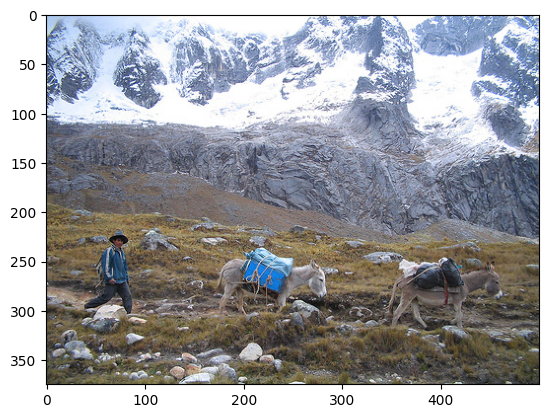

In [64]:
# Some Examples
generate_caption("56489627_e1de43de34.jpg")

---------------------Actual---------------------
startseq children sit and watch the fish moving in the pond endseq
startseq people stare at the orange fish endseq
startseq several people are standing near fish pond endseq
startseq some children watching fish in pool endseq
startseq there are several people and children looking into water with blue tiled floor and goldfish endseq
--------------------Predicted--------------------
startseq two men are sitting on bench endseq


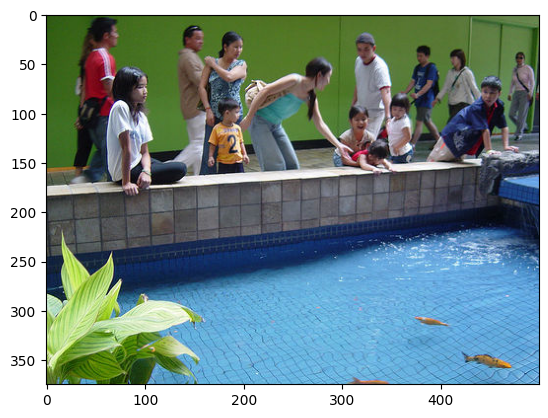

In [65]:
generate_caption("12830823_87d2654e31.jpg")

---------------------Actual---------------------
startseq climber wearing white helmet is perched on the side of rock face endseq
startseq lone climber wearing white helmet climbing wall endseq
startseq man wearing blue climbs steep cliff endseq
startseq "the man in blue shirt wearing helmet is readying to climb ." endseq
startseq the rock climber looks down from above endseq
--------------------Predicted--------------------
startseq man is suspended in air with lots of leaves endseq


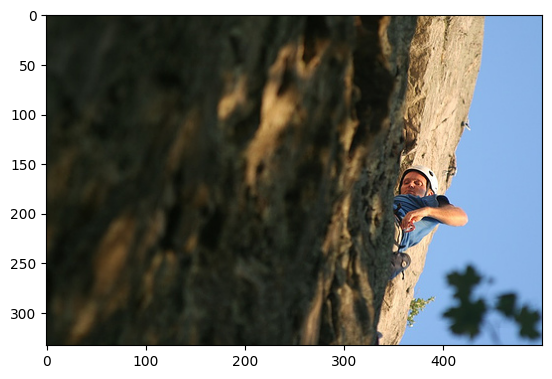

In [67]:
generate_caption("167295035_336f5f5f27.jpg")

---------------------Actual---------------------
startseq girl in colorful clothes on the beach endseq
startseq girl in gold and purple is holding rainbow afghan endseq
startseq girl with colorful clothes is holding colorful scarfs endseq
startseq young woman carries lot of colorful scarves on the beach endseq
startseq woman walking on the beach selling woven items endseq
--------------------Predicted--------------------
startseq two children in colorful costumes endseq


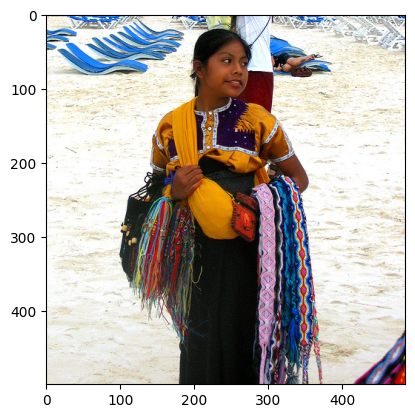

In [70]:
generate_caption("318070878_92ead85868.jpg ")

## Test with Real Image

In [71]:
vgg_model = VGG16()
# restructure the model
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

In [76]:
image_path = "base\Images\997722733_0cb5439472.jpg"
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image for vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)

<>:1: SyntaxWarning: invalid escape sequence '\I'
<>:1: SyntaxWarning: invalid escape sequence '\I'
C:\Users\pc\AppData\Local\Temp\ipykernel_18248\931609469.py:1: SyntaxWarning: invalid escape sequence '\I'
  image_path = "base\Images\997722733_0cb5439472.jpg"


'startseq man is climbing up rock endseq'